Loads Network performance data from ES. Learns to predict bandwidth from packet loss and one way delay.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re,time
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)


In [3]:
ind='network_weather_2-2016.6.22'

currentTime=int(round(datetime.utcnow().timestamp()* 1000))
lastHours=24
startTime=currentTime - lastHours*3600000 
endTime=currentTime

source='MWT2'
destination='AGLT2'

In [3]:
myquery={
#    "size":50,
    "fields": ["timestamp", "delay_mean","throughput","packet_loss"],
    "query":{
        "filtered":{
            "query":{
                "bool" : {
                  "must" :     [ 
                        {"term": {"srcProduction": {"value": True } } },
                        {"term": {"destProduction": {"value": True } } },
                        {"term": {"srcSite": { "value": source } } },
                        {"term": {"destSite": { "value": destination } } }
                    ]
                }
#               "query_string":{"query":queryString,"analyze_wildcard":True,"lowercase_expanded_terms":False}
            }
#            ,"filter":{ "range":{"timestamp":{"gte": startTime,"lte": endTime,"format": "epoch_millis"}}   }
        }
    }
#    ,"sort": { "timestamp": { "order": "asc" }}
}

In [4]:
scroll = scan(es, query=myquery, index=ind, scroll='10s')
RawData={}
count=0
for res in scroll:
    #print(res)
    r = res['fields']
    sts = r['timestamp'][0]
    ts=time.mktime(datetime.strptime(sts, "%Y-%m-%dT%H:%M:%S").timetuple())
    if not ts in RawData:
        RawData[ts]=[-1,-1,-1]
    if res['_type']=='latency':
        RawData[ts][0]=r['delay_mean'][0]
    elif res['_type']=='packet_loss_rate':
        RawData[ts][1]=r['packet_loss'][0]
    elif res['_type']=='throughput':
        RawData[ts][2]=r['throughput'][0]
    count+=1
    
print ("results fetched:", count ) 
print ("results summed up:", len(RawData) ) 

tss = sorted(RawData.keys())
for r in tss:
    print(r, RawData[r])


results fetched: 2582
results summed up: 255
1466561100.0 [8.078533333333334, 0.0, -1]
1466561400.0 [7.062533333333333, 0.0, -1]
1466561700.0 [7.291399999999999, 0.0, -1]
1466562000.0 [6.211533333333333, 0.0, -1]
1466562300.0 [6.234933333333333, 0.0, -1]
1466562600.0 [12.828083333333321, 0.0, -1]
1466562900.0 [5.415233333333334, 0.0, -1]
1466563200.0 [5.751866666666667, 0.0, -1]
1466563500.0 [14.53943333333333, 0.0, -1]
1466563800.0 [4.910083333333334, 0.0, -1]
1466564100.0 [5.2547500000000005, 0.0002777777777777778, -1]
1466564400.0 [6.637933333333333, 0.0, -1]
1466564562.0 [-1, -1, 824058322.0]
1466564700.0 [5.805111111111111, 0.0, -1]
1466565000.0 [5.9201999999999995, 0.0, -1]
1466565031.0 [-1, -1, 2225659000.0]
1466565300.0 [6.878533333333334, 0.0003333333333333333, -1]
1466565600.0 [6.603750000000002, 0.0, -1]
1466565900.0 [5.8652, 0.0, -1]
1466566200.0 [5.829933333333333, 0.0, -1]
1466566500.0 [5.799766666666667, 0.0, -1]
1466566800.0 [5.493266666666666, 0.0, -1]
1466567100.0 [6.

cleaning the data - create array where all 3 components are there.

In [5]:
X=[]
y=[]
for (k,v) in RawData.items():
    if v[2]==-1: continue
    delay_measurements=0
    pl_measurements=0
    delay_sum=0
    pl_sum=0
    for (k1,v1) in RawData.items():
        if abs(k1-k)<600:
            if v1[0]>-1:
                delay_measurements+=1
                delay_sum+=v1[0]
            if v1[1]>-1:
                pl_measurements+=1
                pl_sum+=v1[1]
            #print(k, k1)
    if pl_measurements>0 and delay_measurements>0:
#         print (k, v, delay_sum/delay_measurements, pl_sum/pl_measurements)
        X.append([ delay_sum/delay_measurements, pl_sum/pl_measurements ])
        y.append(v[2]/1024/1024/1024/8)
#print(X)
#print(y)

[[6.081250000000001, 0.0003333333333333333], [6.51834375, 0.0], [4.81840918917417, 0.0], [5.040592522507502, 0.0], [5.9538502610347175, 0.00125], [9.934825, 8.333333333333333e-05], [5.380617489808455, 0.0005], [7.926495833333334, 0.0], [6.749979166666667, 0.0], [5.552083588648047, 0.0], [6.9370992476658895, 0.0], [6.263725, 0.0], [9.811297004557074, 0.0], [7.523404166666667, 0.00016666666666666666], [6.737558333333334, 0.0], [6.088549126097588, 0.0], [5.516881401127429, 0.0003333333333333333], [5.97015, 0.0], [6.0473658836770285, 0.0005833333333333333], [5.5458638888888885, 0.0], [5.297804027702702, 8.333333333333333e-05], [6.2605044219813815, 0.0], [6.410264807713683, 8.333333333333333e-05], [6.571921533759379, 6.944444444444444e-05], [7.922564104474319, 0.0], [6.930918749999999, 0.0003333333333333333], [7.276229166666667, 8.333333333333333e-05], [5.283358333333334, 0.0], [7.003729839113038, 0.0], [7.523475000000001, 0.0], [8.042474545378713, 0.0004583333333333334], [6.846954867092712

takes as input two arrays: an array X of size [n_samples, n_features] holding the training samples, and an array y of class labels (strings or integers), size [n_samples]

Learning step:

In [6]:
from sklearn import svm
# X = [[0, 0], [1, 1], [1, 1.2], [0.5, 0.8]]
#y = [1.2, 2.2]
clf = svm.SVR()
f = clf.fit(X, y)
print(f)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Using what was learned

In [7]:
clf.predict([[1., .02],[0.1,1.0]])

array([ 0.21804452,  0.21785421])

plot values

In [29]:
na=np.array(X)
#print(na)

In [30]:
owd=na[:,0]
pl=na[:,1]
ar=np.array(y)*100

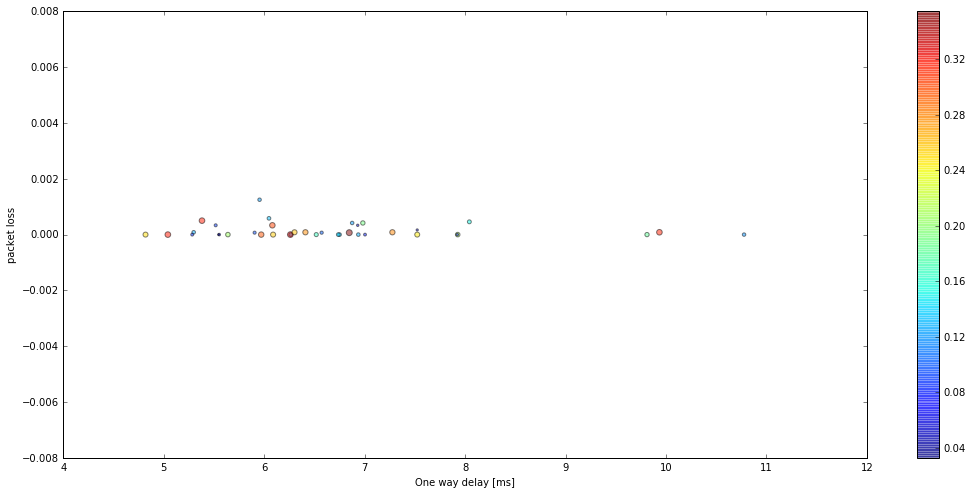

In [31]:
area = np.pi * 6**2 # 0 to 15 point radiuses
plt.figure(figsize=[18, 8])
plt.scatter(owd, pl, s= ar, c=y, alpha=0.5)
plt.colorbar()
plt.xlabel('One way delay [ms]'), plt.ylabel('packet loss')
plt.show()